## Семинар 8: "Снижение размерности"

ФИО: Находнов Максим Сергеевич

In [80]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import sys
%matplotlib inline

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [81]:
X = fetch_olivetti_faces()['data']

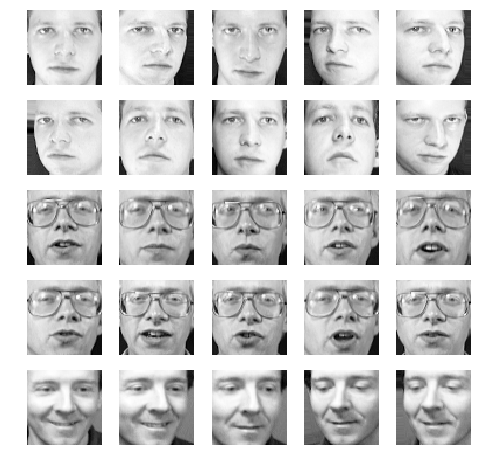

In [82]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [83]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

In [84]:
model = PCA(n_components=25)
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [85]:
principle_components = model.components_

In [86]:
principle_components.shape

(25, 4096)

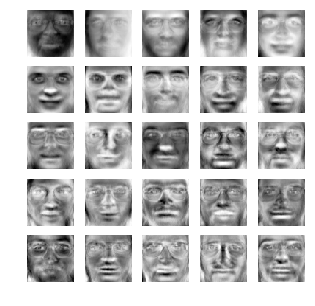

In [87]:
plt.figure(figsize=(5, 5))
for idx, comp in enumerate(principle_components):
    plt.subplot(5,5,idx+1)
    data = comp.reshape(64, 64)
    plt.imshow(data, cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте методы <b>.explained\_variance\_ratio\_</b> и <b>np.cumsum()</b>

In [88]:
model = PCA()
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

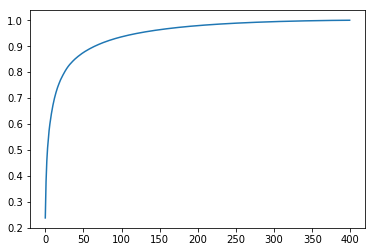

In [89]:
plt.plot(np.cumsum(model.explained_variance_ratio_))

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют? Чему соответствуют главные компоненты?</i>

In [90]:
model = PCA(n_components=2)
model.fit(X)
X_pass = model.transform(X)
X_pass_passback = model.inverse_transform(X_pass)

In [91]:
# Код для отображения изображений в 2D
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in xrange(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

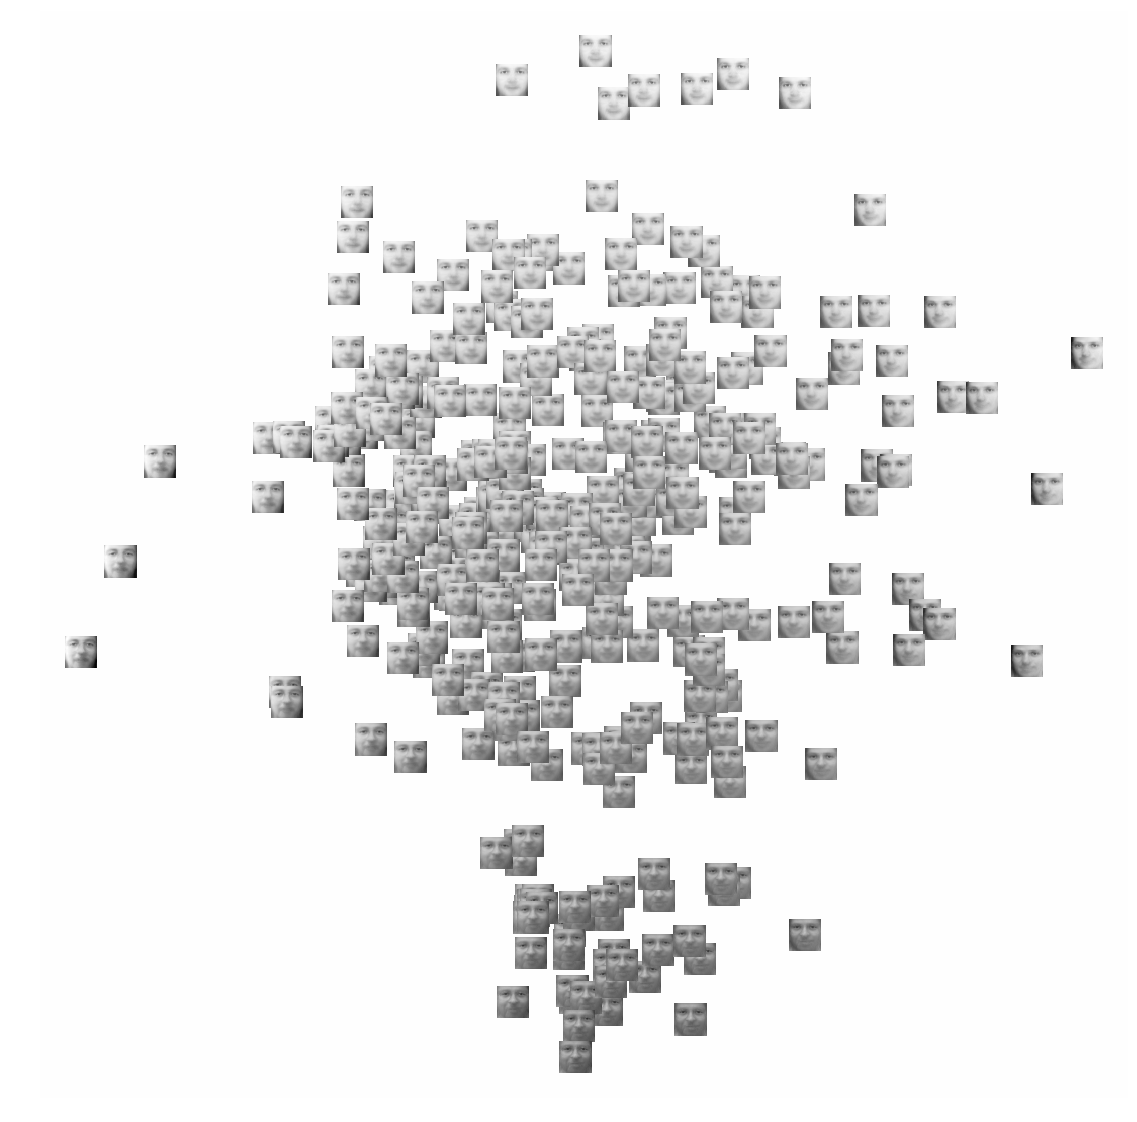

In [92]:
plot_dataset(X_pass_passback, X_pass)

Вдоль 1 компоненты меняется яркость изображения, вдоль 2 - поворот лица

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [14]:
torch.cuda.set_device(2)

In [15]:
def make_network(arc, last_sigm = False):
    layers = []
    for idx in xrange(len(arc) - 1):
        layers.append(nn.Linear(arc[idx], arc[idx + 1]))
        if idx == len(arc) - 2 and not last_sigm:
            break
        layers.append(nn.Sigmoid())
        layers.append(nn.BatchNorm1d(arc[idx + 1]))
    return nn.Sequential(*layers)

In [16]:
class AutoEncoder(nn.Module):
    def __init__(self, arc_encoder, arc_decoder):
        nn.Module.__init__(self);
        self.encoder = arc_encoder
        self.decoder = arc_decoder
        
    def forward(self, X):
        X = self.encoder(X)
        X = self.decoder(X)
        return X

In [17]:
network = AutoEncoder(make_network([4096, 200, 10], True), make_network([10, 200, 4096], False)).cuda()

In [18]:
from torch.utils.data import DataLoader, Dataset
X_Tensor = torch.FloatTensor(torch.from_numpy(X)).cuda()
X_Tensor -= X_Tensor.mean(0, keepdim=True)
dataloader = DataLoader(X_Tensor, 400, shuffle=True)

<i> 2.2 Какое качество восстановления удалось получить?</i>

In [19]:
def train(network, epochs, learning_rate, silent=False):
    loss = nn.MSELoss().cuda()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            for X in dataloader:
                X = Variable(X).cuda()
                y = X
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
            train_loss_epochs.append(np.mean(losses))
            losses = []
            accuracies = []    
            for X in dataloader:
                X = Variable(X).cuda()
                y = X
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE_LOSS: {1:.3f}/{2:.3f}\t'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    if not silent:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_epochs, label='Train')
        plt.plot(test_loss_epochs, label='Test')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()

Epoch 999... (Train/Test) MSE_LOSS: 0.015/0.015	

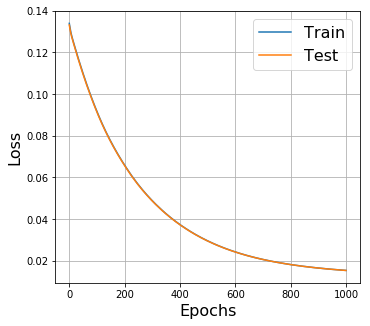

In [20]:
train(network, 1000, 0.00001)

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
model = PCA(n_components=10)
model.fit(X_Tensor)
X_pass = model.transform(X_Tensor)
X_pass_backpass = model.inverse_transform(X_pass)
print mean_squared_error(X_Tensor, X_pass_backpass)

0.006621544221142613


<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [64]:
latent_spaces = np.append(np.arange(1, 10), np.round(np.logspace(1, 2.5, 20)).astype(int))

In [65]:
networks = []
for latent_shape in latent_spaces:
    networks.append(AutoEncoder(make_network([4096, 200, latent_shape], True), make_network([latent_shape, 200, 4096], False)).cuda())

In [66]:
evrs = np.zeros(len(networks))

X_Variable = Variable(X_Tensor, requires_grad=False).cuda()
X_Variable -= X_Variable.mean(0, keepdim=True)
for idx, latent_space in enumerate(latent_spaces):
    print latent_space
    for _ in xrange(2000 / 100):
        train(networks[idx], 100, 0.01, True)
        y = networks[idx](X_Variable)
        err2 = ((y - X_Variable) ** 2).sum(1).mean()
        evr = 1 - err2 / (X_Variable ** 2).sum(1).mean()
        evr = evr.data.cpu().numpy()[0]
        evrs[idx] = max(evr, evrs[idx])

1
Epoch 99... (Train/Test) MSE_LOSS: 0.012/0.012	2
Epoch 99... (Train/Test) MSE_LOSS: 0.006/0.006	3
Epoch 99... (Train/Test) MSE_LOSS: 0.003/0.003	4
Epoch 99... (Train/Test) MSE_LOSS: 0.002/0.002	5
Epoch 99... (Train/Test) MSE_LOSS: 0.002/0.002	6
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	7
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	8
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	9
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	10
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	12
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	14
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	17
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	21
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	25
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	30
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	36
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	43
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	51
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	62
Epoch 99... (Train/Test) MSE_LOSS: 0.001/0.001	74
Epoch 

In [67]:
evrs

array([0.37957138, 0.70355141, 0.82023656, 0.88526452, 0.91285914,
       0.93394327, 0.9386788 , 0.94368666, 0.94803143, 0.94971132,
       0.95352507, 0.95547175, 0.95880347, 0.96249318, 0.96393013,
       0.96644896, 0.9688136 , 0.96992105, 0.97106439, 0.9724068 ,
       0.97311676, 0.97386748, 0.97499365, 0.97505343, 0.97700083,
       0.97761679, 0.97678101, 0.97797477, 0.97852737])

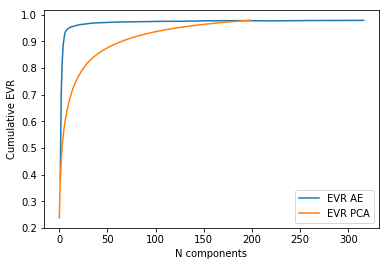

In [68]:
model = PCA()
model.fit(X)

plt.plot(latent_spaces, evrs, label='EVR AE')
plt.plot(np.cumsum(model.explained_variance_ratio_)[:200], label='EVR PCA')
plt.xlabel('N components')
plt.ylabel('Cumulative EVR')
plt.legend()

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [69]:
network = AutoEncoder(make_network([4096, 200, 100, 2], True), make_network([2, 100, 200, 4096], False)).cuda()

Epoch 999... (Train/Test) MSE_LOSS: 0.009/0.009	

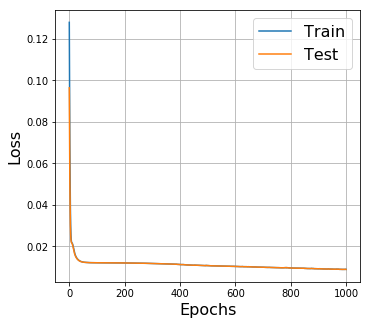

In [70]:
train(network, 1000, 0.001)

In [71]:
X_pass = network.encoder(X_Variable).data.cpu().numpy()

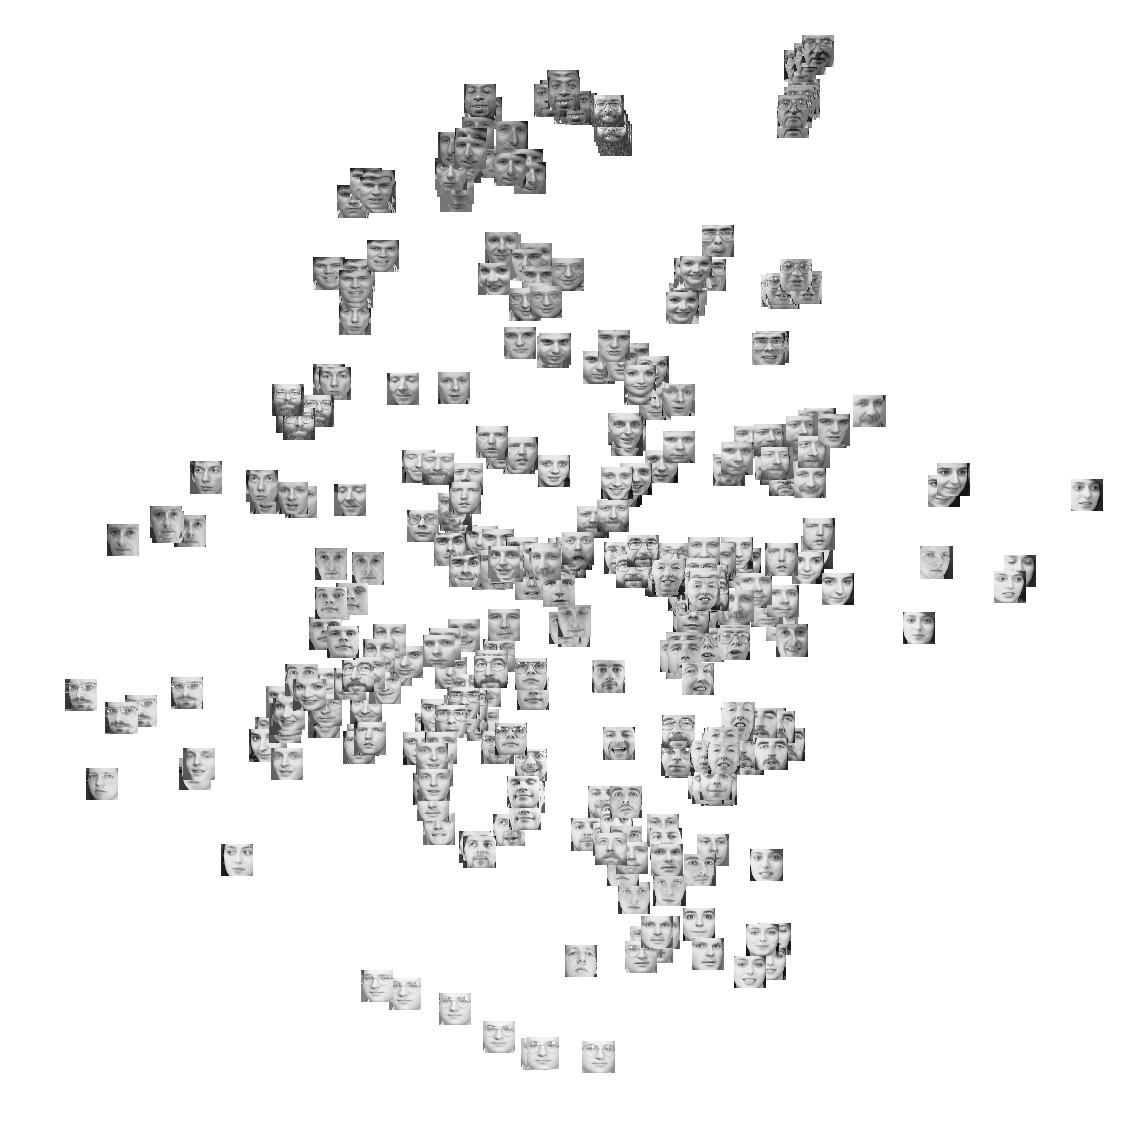

In [78]:
plot_dataset(X, X_pass)

Кластеры соответствуют лицам похожих людей

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: